# Training of Models with Helen*

> Taken from: "https://github.com/JPlin/Relabeled-HELEN-Dataset"


# Read dataset from disk to RAM

In [2]:
!wget   http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_5_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_5_face_landmarks.dat"

--2023-02-05 21:23:15--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  2.39MB/s    in 2.3s    

2023-02-05 21:23:17 (2.39 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

bunzip2: Output file /content/shape_predictor_5_face_landmarks.dat already exists.


In [332]:
import cv2
import glob
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import dlib
import torchvision
from torchvision import transforms

""" HAAR CASCADE CLASSIFIER AND ROATER"""

def shape_to_normal(shape):
  shape_normal = []
  for i in range(0, 5):
      shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
  return shape_normal

def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def cosine_formula(length_line1, length_line2, length_line3):
  cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
  return cos_a

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

def align(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #face alignment
    rects = detector(gray, 0)
    if len(rects) > 0:
        for rect in rects:
            x = rect.left()
            y = rect.top()
            w = rect.right()
            h = rect.bottom()
            shape = predictor(gray, rect)
    else:
      return 0

    shape = shape_to_normal(shape)
    nose, left_eye, right_eye = get_eyes_nose_dlib(shape)

    center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    center_pred = (int((x + w) / 2), int((y + y) / 2))

    length_line1 = distance(center_of_forehead, nose)
    length_line2 = distance(center_pred, nose)
    length_line3 = distance(center_pred, center_of_forehead)

    cos_a = cosine_formula(length_line1, length_line2, length_line3)
    angle = np.arccos(cos_a)

    rotated_point = rotate_point(nose, center_of_forehead, angle)
    rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
    if is_between(nose, center_of_forehead, center_pred, rotated_point):
        angle = np.degrees(-angle)
    else:
        angle = np.degrees(angle)
    
    #gray = Image.fromarray(gray)
    #gray = np.array(gray.rotate(angle))

    return angle


#Resize images (height  = X, width = Y)
SIZE_X = 128 
SIZE_Y = 128
#Ensure MLP Is ony fed 1000/ Dataset
SAMPLE_SIZE = 1998

# crop face using haar cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

crops = []
original = 0
skips = []
rejected = []
angles = []

"""IMG"""
#Capture training image info as a list
train_images = []
val_images = []
for count, img_path in enumerate(sorted(glob.glob(os.path.join("/content/drive/MyDrive/helenstar_release/train/", "*image.jpg")))):
    #Process images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #cv2_imshow(img)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #train_images.append(img)
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # face bounding boxes
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(datFile)  

    face = None

    # Detect faces
    try:
      face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
      limit = int((gray.shape[0]/2))
      faces = face_cascade.detectMultiScale(gray, 1.05, 2, minSize=[limit,0])
      face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
    except:
      #print("FAILED USING FRONTAL FACE ALT 2")
      try:
        face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml")
        limit = int((gray.shape[0]/2))
        faces = face_cascade.detectMultiScale(gray, 1.05, 2, minSize=[limit,0])
        face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
      except:
        try:
          face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
          limit_1 = int((gray.shape[0]/2.5))
          limit_2 = int((gray.shape[1]/1.7))
          faces = face_cascade.detectMultiScale(gray, 1.05, 3, minSize=[limit_1,0], maxSize=[50000,limit_2]) 
          face = sorted(faces,key=lambda f:f[2]*f[3])[-1]  
        except:
          #print("FAILED USING FRONTAL FACE ALT 2")
          try:
            face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
            limit_1 = int((gray.shape[0]/2.5))
            limit_2 = int((gray.shape[1]/2.5))
            faces = face_cascade.detectMultiScale(gray, minSize=[0,limit_2])
            face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
          except:
            #print("FAILED USING FRONTAL FACE ALT 2")
            try:
              face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
              limit_1 = int((gray.shape[0]/2))
              limit_2 = int((gray.shape[1]/3))
              faces = face_cascade.detectMultiScale(gray, 1.03, 1, minSize=[limit_1,0])
              face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
            except:
              #print("FAILED USING PROFILE FACE ALT")
              print("->")
              skips.append(count)
              rejected.append(gray)
              crops.append([0,0,0,0])

    if face is not None:
      x, y, w, h = face
      crops.append(face)
      face = img[y:y + h, x:x + w]
      face = cv2.resize(face, (SIZE_Y, SIZE_X))
      #cv2_imshow(face)

      angle = align(img)
      face = Image.fromarray(face)
      face_rotated = np.array(face.rotate(angle))
      angles.append(angle)
      #cv2_imshow(face_rotated)
      
      #normed_face = preprocess(face_rotated)
      #print(normed_face.shape)

      train_images.append(face_rotated)
      #preview = torchvision.transforms.functional.to_pil_image(normed_face)
      #print(preview.shape)
      #plt.imshow(preview,cmap='gray', vmin=0, vmax=1)
      #plt.show()
      

    # Stop after SAMPLE_SIZE is reached
    if count % 9 == 0:
      print(str(count), "/", str(SAMPLE_SIZE)) #, end='\r'
    if count == SAMPLE_SIZE -1:
      break

X = torch.tensor(train_images).permute(0,3,1,2)
#X= torch.stack(train_images)
print(X.shape)


0 / 1998
9 / 1998
18 / 1998
->
27 / 1998
->
36 / 1998
45 / 1998
->
54 / 1998
63 / 1998
72 / 1998
->
81 / 1998
90 / 1998
->
99 / 1998
108 / 1998
117 / 1998
->
->
126 / 1998
->
135 / 1998
144 / 1998
153 / 1998
->
->
162 / 1998
171 / 1998
180 / 1998
->
->
189 / 1998
198 / 1998
207 / 1998
216 / 1998
->
225 / 1998
234 / 1998
243 / 1998
252 / 1998
261 / 1998
->
270 / 1998
279 / 1998
288 / 1998
297 / 1998
306 / 1998
315 / 1998
->
324 / 1998
333 / 1998
342 / 1998
351 / 1998
360 / 1998
369 / 1998
->
378 / 1998
387 / 1998
->
396 / 1998
->
405 / 1998
->
414 / 1998
->
423 / 1998
->
432 / 1998
441 / 1998
450 / 1998
459 / 1998
468 / 1998
477 / 1998
486 / 1998
->
495 / 1998
504 / 1998
->
513 / 1998
522 / 1998
531 / 1998
540 / 1998
->
549 / 1998
->
558 / 1998
->
->
567 / 1998
576 / 1998
585 / 1998
594 / 1998
603 / 1998
612 / 1998
621 / 1998
->
630 / 1998
->
639 / 1998
648 / 1998
657 / 1998
->
666 / 1998
675 / 1998
->
684 / 1998
693 / 1998
702 / 1998
711 / 1998
->
720 / 1998
729 / 1998
->
738 / 1998
74

In [333]:
"""MASK"""
# Capture mask/label info as a list
masks = np.empty(shape=(int(len(train_images)),11,SIZE_Y,SIZE_Y))
print(len(crops))
print(len(train_images))
suc_count = 0
for count, mask_path in enumerate(sorted(glob.glob(os.path.join("/content/drive/MyDrive/helenstar_release/train/", "*label.png")))):
    # Process images
    mask = cv2.imread(mask_path, 0)

    # retrieve x,y,h,w
    face = crops[count]
    #print(face)

    #print(sum(face))

    if sum(face) != 0:
      x, y, w, h = face
      #print(face.size)
      face = mask[y:y + h, x:x + w]
      #print(face.size)
      #print(face.shape)
      mask = cv2.resize(face, (SIZE_Y, SIZE_X))

      mask = Image.fromarray(mask)
      mask = np.array(mask.rotate(angles[suc_count]))

      #plt.imshow(mask, cmap='gray')
      #plt.show()
      # one hot encode
      one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11)
      one_hot_Y = one_hot_Y.permute(2,0 , 1)


      # save
      masks[suc_count]= (one_hot_Y)
      suc_count +=1
    else:
      pass


    """END OF Y"""
    # Stop after SAMPLE_SIZE is reached
    print(str(count), "/", str(SAMPLE_SIZE), end='\r')
    if count == SAMPLE_SIZE -1:
      break

Y = torch.from_numpy(masks)

print(Y.shape)
print(original)

1998
1913
torch.Size([1913, 11, 128, 128])
0


In [334]:
print(Y.shape)
print(X.shape)

torch.Size([1913, 11, 128, 128])
torch.Size([1913, 3, 128, 128])


### Obtain semantic class values for facial features in the dataset's images

0: background
1: facial skin
2: left brow (viewer side)
3: right brow
4: left eye
5: right eye
6: nose
7: upper lip
8: inner mouth
9: lower lip
10: hair

In [335]:
#rgb_vals = np.unique(ar = Y.numpy())
rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]
print(rgb_vals)

num_classes=len(rgb_vals)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [336]:
# Helper functions from "https://github.com/HardevKhandhar/building-segmentation-image-processing/blob/main/geospatial_buildings.ipynb"

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          plt.title(name.replace('_',' ').title(), fontsize=20)
          #print(image.shape)
          preview = torchvision.transforms.functional.to_pil_image(image)
          plt.imshow(preview,cmap='gray', vmin=0, vmax=1)
        else:
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [337]:
X[3].shape

torch.Size([3, 128, 128])

### Sanity check

0


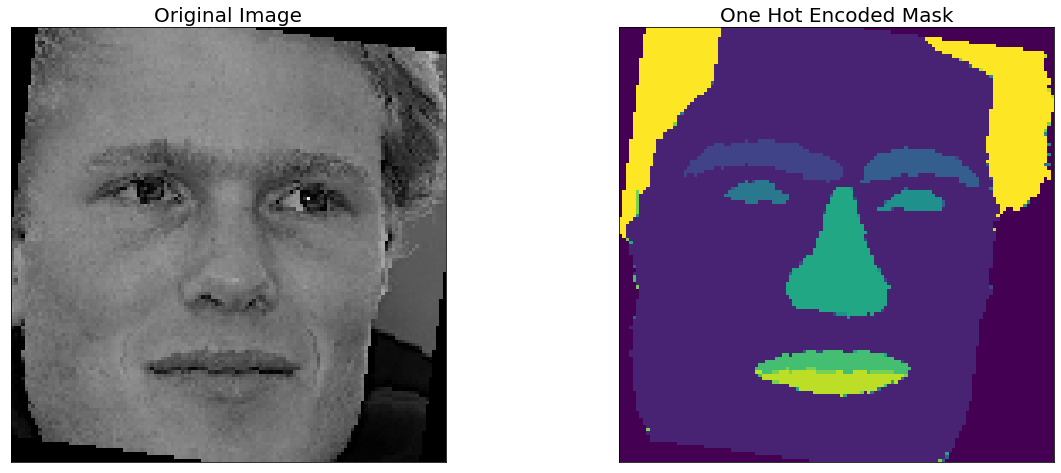

1


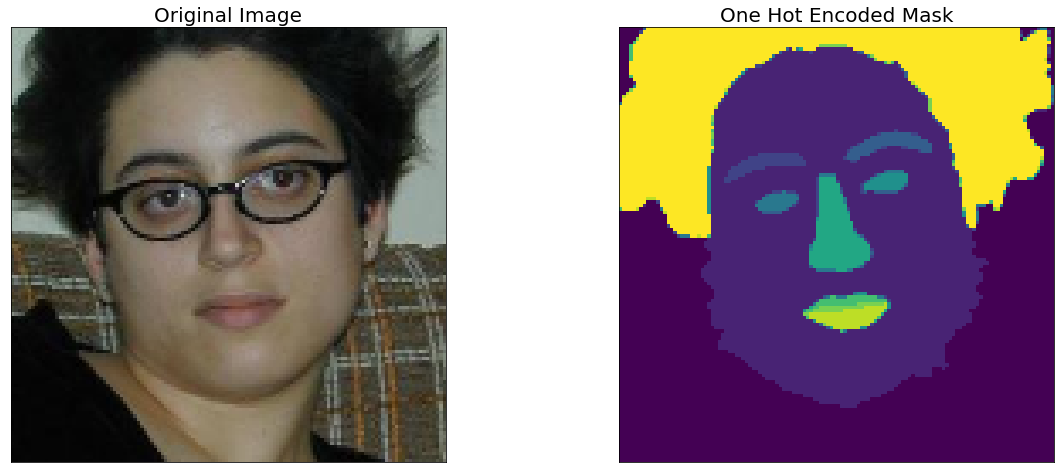

2


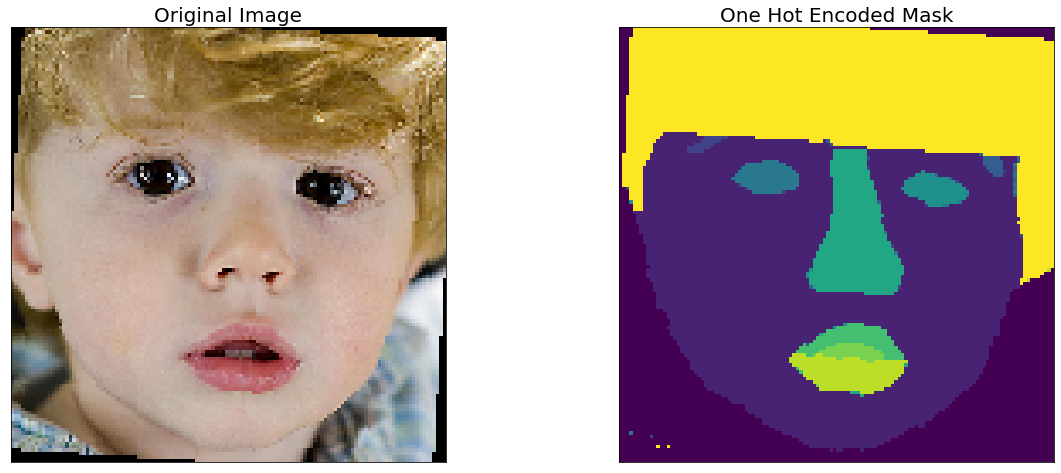

3


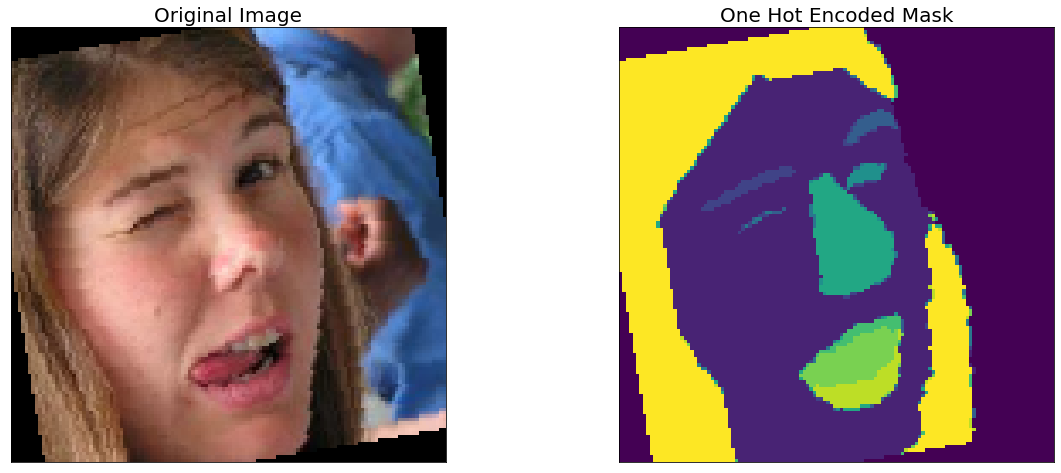

4


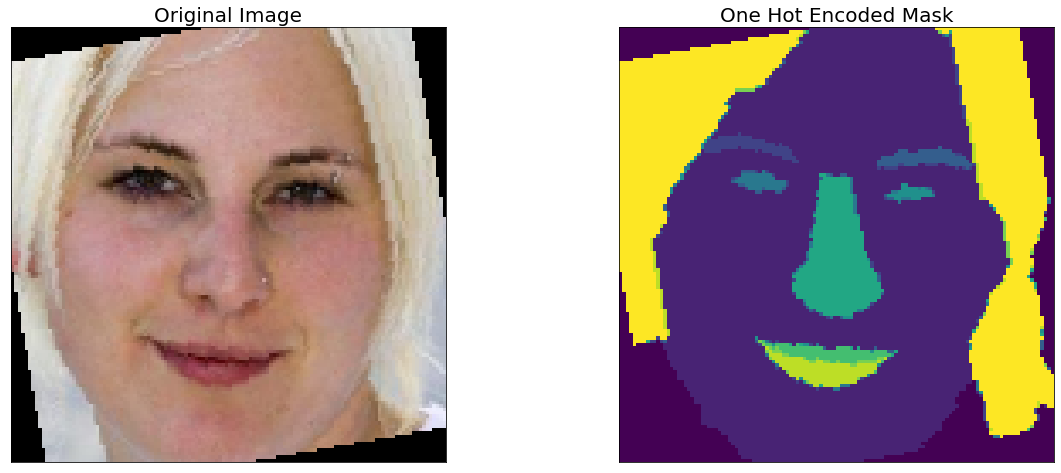

In [338]:
import matplotlib.pyplot as plt


for x in range(len(X[:5])):
  print(x)
  visualize(
      original_image = X[x],
      #ground_truth_mask = colour_code_segmentation(reverse_one_hot(y_test[0]), rgb_vals),
      one_hot_encoded_mask = reverse_one_hot(Y[x])
  )

#reverse_one_hot(Y[0]).shape

## Augment

In [339]:
import torchvision
import torchvision
import random

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 25.0
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

def augment(x,y):
    if 0 == 0:
      # rotate XY
      prob_rot = random.randint(0,10)
      if prob_rot > 8:
        r = random.randint(-18,18)
        x = torchvision.transforms.functional.rotate(x, r)
        y = torchvision.transforms.functional.rotate(y, r)

      # persepective warp XY with percentage: 40% WARP
      prob_warp = random.randint(0,10)
      starting_coords = [[0,SIZE_Y],[SIZE_X,SIZE_Y], [0,0], [SIZE_X,0]]
      end_coords = starting_coords
      if prob_warp > 8:
        
        for coord in end_coords:
          for val in coord:
            transformation = random.random()
            val = val * transformation

        x, y = torchvision.transforms.functional.perspective(x, starting_coords, end_coords), torchvision.transforms.functional.perspective(y, starting_coords, end_coords)

      # (Gaussian) blurs XY with percentage: 30% BLUR
      prob_blur = random.randint(0,10)
      if prob_blur > 8:
        blurrer = torchvision.transforms.GaussianBlur(kernel_size=(3,5))
        x, y = blurrer(x), blurrer(y)

      # (Gaussian) noise XY with percentage: 30% noise
      #prob_noise = random.randint(0,10)
      #if prob_noise > 8:
      #  x = gauss_noise_tensor(x)

      #modulations to brightness and contrast X with percentage: 30% MODULATION
      prob_mod = random.randint(0,10)
      if prob_mod > 8:
        jitter = torchvision.transforms.ColorJitter()
        x = jitter(x)

      #print("auged")

      #prob_mod = random.randint(0,10)
      #if prob_mod > 0.7:
      #  x = F.hflip(x)
      #  y = F.hflip(y)

    #conversion to grayscale X
    #x = T.Grayscale()(x)
    
    return x,y

### Train/Test Split

In [340]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(x_train.shape)
print(y_train.shape)

torch.Size([1530, 3, 128, 128])
torch.Size([1530, 11, 128, 128])


## Dataset creation

In [341]:
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [342]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [343]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

SIZEX = 128
SIZEY = 128

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        #albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, x, y, preprocessing=None, classes=None,augmentation=None):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image = x
    self.mask = y

  def __len__(self):
    # a DataSet must know it size
    return len(self.image)

  def __getitem__(self, i):
    image, mask = self.image[i].permute(1,2,0), self.mask[i].permute(1,2,0)

    #print(image.shape, mask.shape)

    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=np.array(image), mask=np.array(mask))
        image, mask = sample['image'], sample['mask']

    #print(image.shape, mask.shape)
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    #print(image.shape, mask.shape)

    #onehot
    #one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).permute(0,3,1,2).float()

    return (torch.tensor(image).permute(2,0,1).float(), torch.tensor(mask).permute(2,0,1).float())


train_ds = MyDataSet(x_train, y_train, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds = MyDataSet(x_test, y_test, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())

te, te2 = val_ds[0]

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


### Data Loader

In [344]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

print(len(train_loader))

24


### (DataLoader) Sanity check

TRAIN:
torch.Size([64, 3, 128, 128])
torch.Size([64, 11, 128, 128])


<ipython-input-345-5a96c3342d07>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


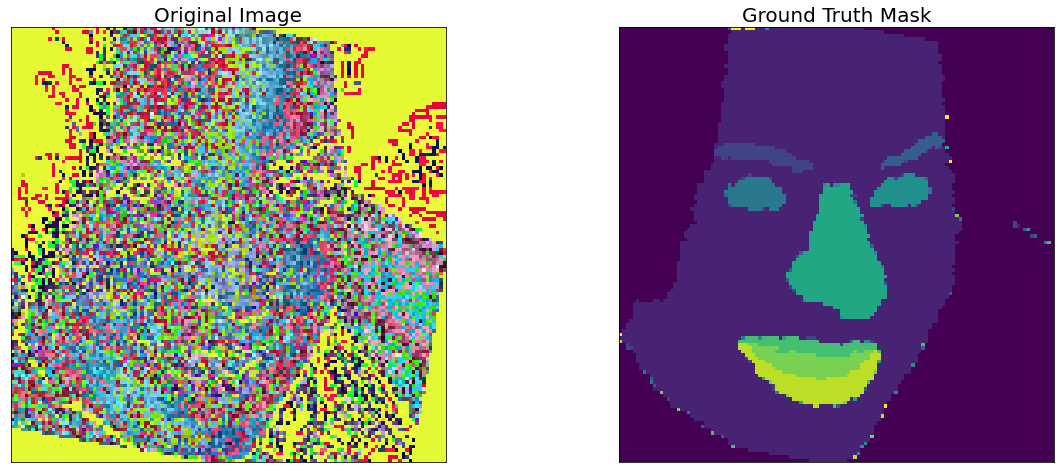

torch.Size([64, 3, 128, 128])
torch.Size([64, 11, 128, 128])


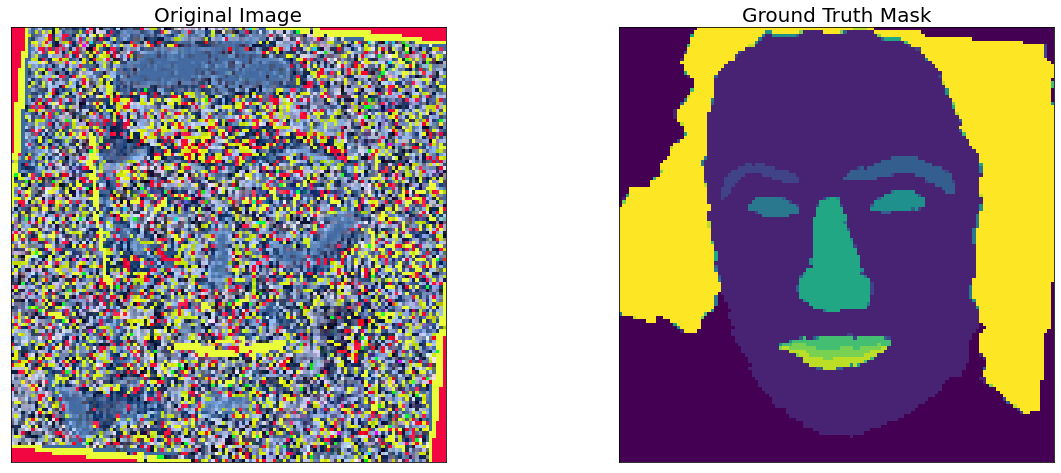

torch.Size([64, 3, 128, 128])
torch.Size([64, 11, 128, 128])


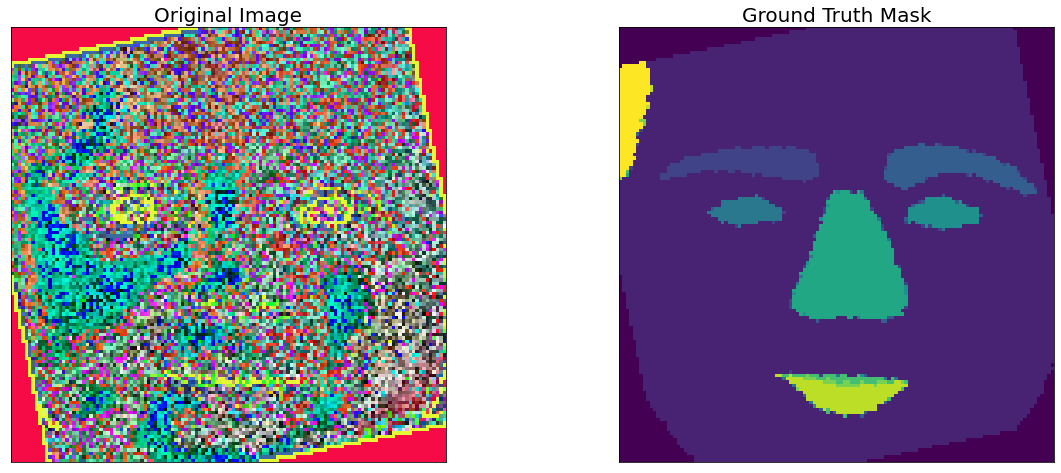

torch.Size([64, 3, 128, 128])
torch.Size([64, 11, 128, 128])


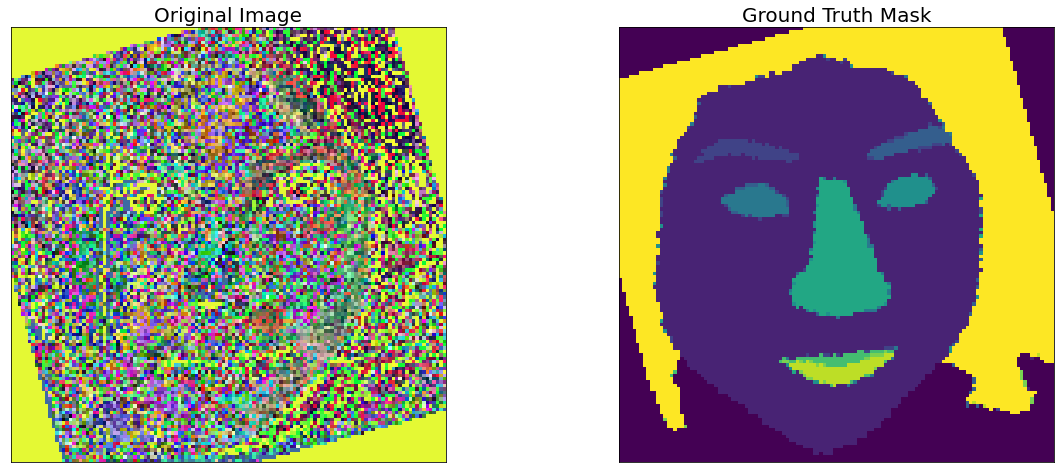

torch.Size([64, 3, 128, 128])
torch.Size([64, 11, 128, 128])


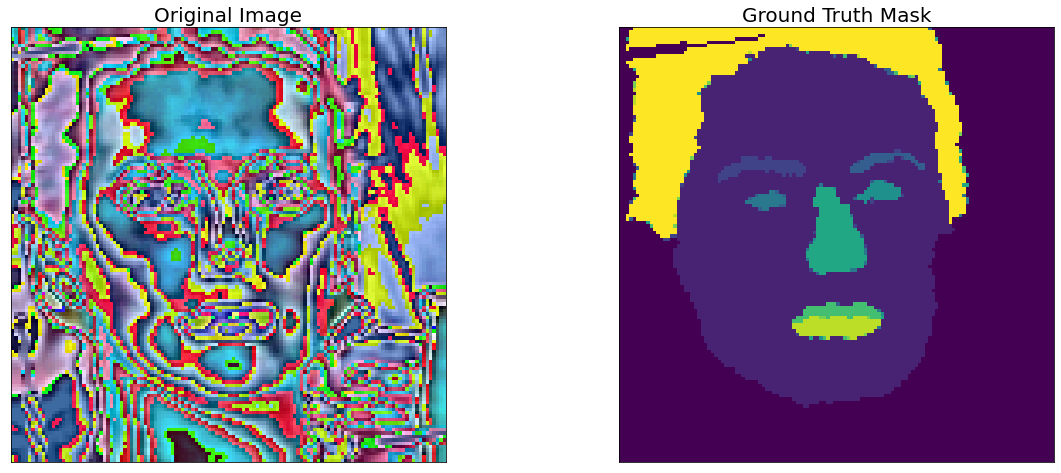

VAL:


In [345]:
print("TRAIN:")
for x in range(5):

    image_vis, gt_mask = next(iter(train_loader))
    print(image_vis.shape)

    print(gt_mask.shape)
    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = gt_mask[0,::]
    )
print("VAL:")
for x in range(0):

    image_vis, gt_mask = next(iter(valid_loader))
    print(image_vis.shape)

    print(gt_mask.shape)
    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = gt_mask[0,::]
    )

In [346]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Initialise Models

In [347]:
! pip install pytorch_toolbelt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [348]:
! pip install focal_loss_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[link text](https:// [link text](https://))### Hyper Parameters

# 1

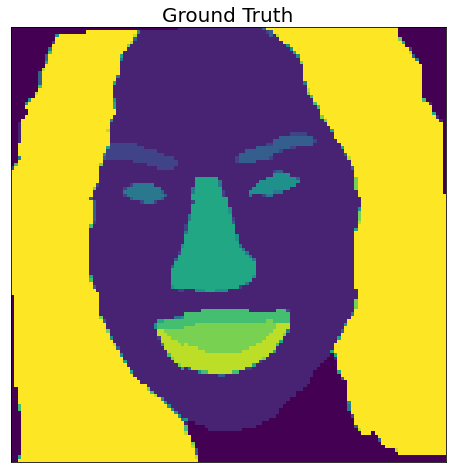

tensor([0.7148, 0.5442, 0.9886, 0.9899, 0.9938, 0.9937, 0.9612, 0.9927, 0.9924,
        0.9884, 0.8403])

In [349]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

# sample weight compute
visualize(
    ground_truth = reverse_one_hot(y_train[2])
)

weights_per_image = []
for image in y_train:
  weights = []
  for layer in np.array(image):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count/65536)
    else:
      weights.append(0)

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights



In [350]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#[0.1, 1, 1, 1, 1, 1, 0.8, 1, 0.8, 1, 0.1]
#weights = weights=torch.tensor()
# define loss function
#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [351]:
import matplotlib.pyplot as plt

def train_model_synth(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')
                
            # Append results to graphs:
           # v_bce.append(valid_logs['bce_loss'])
            v_ious.append(valid_logs['iou_score'])
            
            #t_bce.append(train_logs['bce_loss'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


In [352]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Function to view train model precitions

In [353]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        print("vis:",image_vis.shape)
        print("im:",image.shape)
        
        x_tensor = image.to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        print("predraw", pred_mask.shape)
        print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == num_classes:
        #  f1s.append(f1)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          print(f1)
          f1s.append(np.array(f1))

        if idx < 10:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

In [354]:
from torchvision.utils import save_image
from PIL import Image



def save_predictions(model, ds, path):

  xs = []
  ys = []

  #predict
  for idx in range(len(ds)):

      # Pop image from DS
      image, gt_mask = ds[idx]
      image_vis = image
      image_vis = np.transpose(image_vis,(1,2,0))
      
      # Reshape
      x_tensor = image.to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(x_tensor)
      # Reshape
      pred_mask = pred_mask.detach().squeeze().cpu()
      # Decode Onehots
      pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
      gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

      # Sanity check
    #  print(image_vis.shape)
      #print("GT", gt_mask.shape)
     # print("PRED", pred_mask.shape)

      # Save Predictions for use in Label Adapter
      xs.append(pred_mask)

      ys.append(gt_mask)
      
  return xs, ys

#save_predictions(model, val_ds)

# Predict with Deeplabv3+


Epoch: 1
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.373, iou_score - 0.4671]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.21, iou_score - 0.5408]
Model saved!


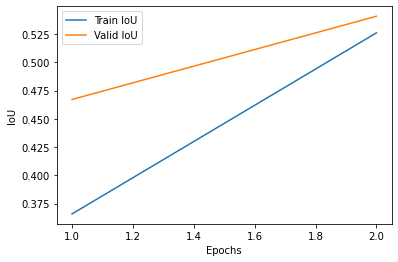


Epoch: 3
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.157, iou_score - 0.6071]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.154, iou_score - 0.6062]


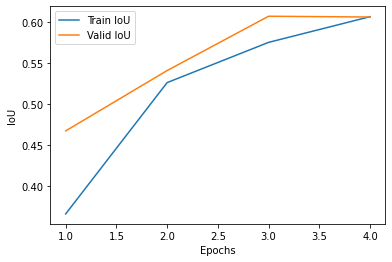


Epoch: 5
valid: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s, cross_entropy_loss - 1.14, iou_score - 0.648]
Model saved!

Epoch: 6
valid: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s, cross_entropy_loss - 1.135, iou_score - 0.6712]
Model saved!


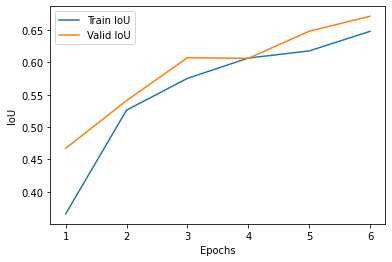


Epoch: 7
valid: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s, cross_entropy_loss - 1.14, iou_score - 0.6463]

Epoch: 8
valid: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s, cross_entropy_loss - 1.137, iou_score - 0.6463]


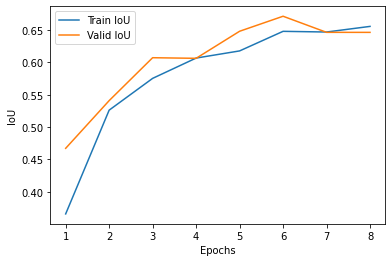


Epoch: 9
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.126, iou_score - 0.6846]
Model saved!

Epoch: 10
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.125, iou_score - 0.6796]


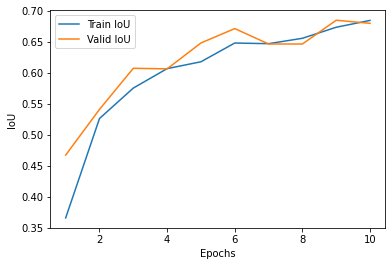


Epoch: 11
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.122, iou_score - 0.6993]
Model saved!

Epoch: 12
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.14, iou_score - 0.6853]


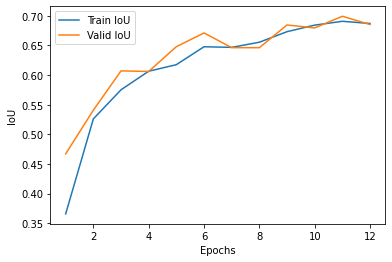


Epoch: 13
valid: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s, cross_entropy_loss - 1.121, iou_score - 0.7054]
Model saved!

Epoch: 14
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.123, iou_score - 0.691]


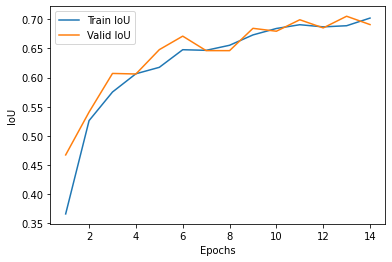


Epoch: 15
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.123, iou_score - 0.6988]

Epoch: 16
valid: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s, cross_entropy_loss - 1.124, iou_score - 0.6929]


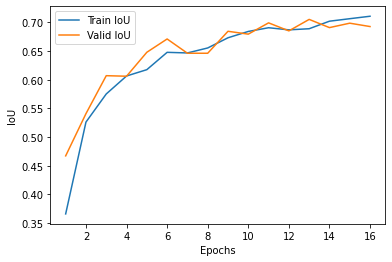


Epoch: 17
valid: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s, cross_entropy_loss - 1.12, iou_score - 0.6995]

Epoch: 18
valid: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s, cross_entropy_loss - 1.121, iou_score - 0.7031]


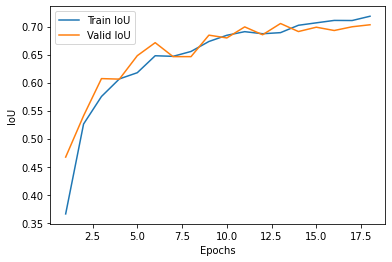


Epoch: 19
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.12, iou_score - 0.7179]
Model saved!

Epoch: 20
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.117, iou_score - 0.7164]


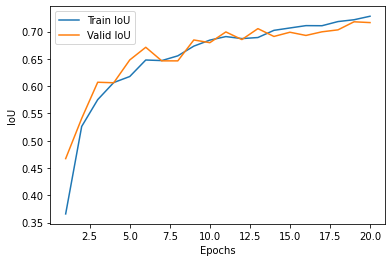


Epoch: 21
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.122, iou_score - 0.7096]

Epoch: 22
valid: 100%|██████████| 6/6 [00:01<00:00,  4.53it/s, cross_entropy_loss - 1.116, iou_score - 0.7259]
Model saved!


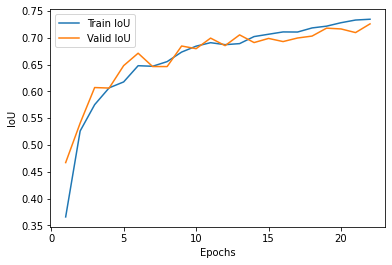


Epoch: 23
valid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, cross_entropy_loss - 1.116, iou_score - 0.7314]
Model saved!

Epoch: 24
valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, cross_entropy_loss - 1.119, iou_score - 0.7205]


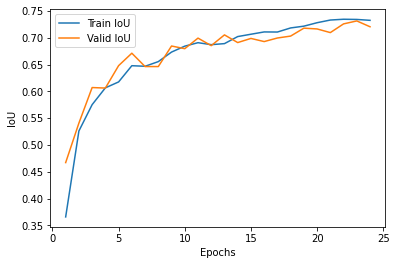


Epoch: 25
valid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, cross_entropy_loss - 1.116, iou_score - 0.7305]

Epoch: 26
valid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, cross_entropy_loss - 1.119, iou_score - 0.7162]


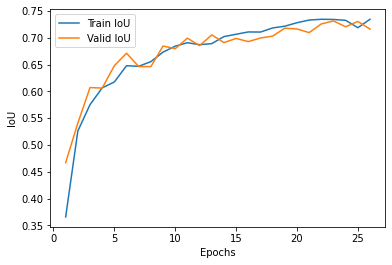


Epoch: 27
valid: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s, cross_entropy_loss - 1.118, iou_score - 0.723]

Epoch: 28
valid: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s, cross_entropy_loss - 1.118, iou_score - 0.7149]


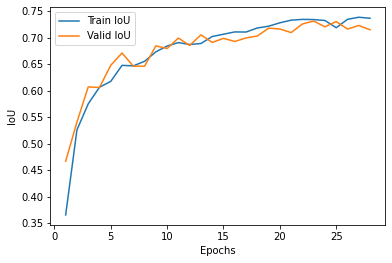


Epoch: 29
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.116, iou_score - 0.7356]
Model saved!

Epoch: 30
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.115, iou_score - 0.7351]


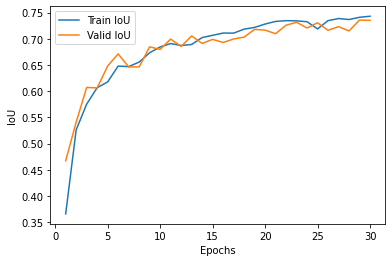


Epoch: 31
valid: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s, cross_entropy_loss - 1.115, iou_score - 0.7354]

Epoch: 32
valid: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s, cross_entropy_loss - 1.116, iou_score - 0.7292]


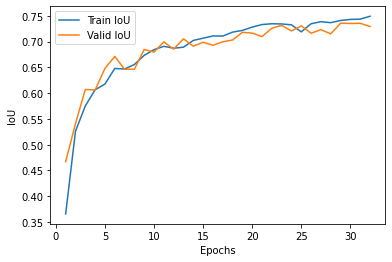


Epoch: 33
valid: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s, cross_entropy_loss - 1.116, iou_score - 0.7332]

Epoch: 34
valid: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s, cross_entropy_loss - 1.115, iou_score - 0.7363]
Model saved!


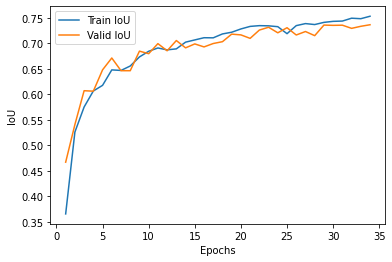


Epoch: 35
valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, cross_entropy_loss - 1.117, iou_score - 0.7274]

Epoch: 36
valid: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s, cross_entropy_loss - 1.114, iou_score - 0.7438]
Model saved!


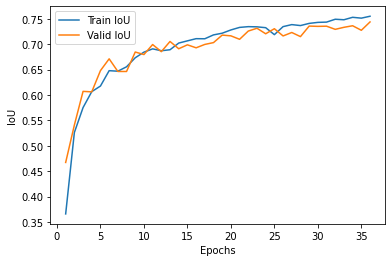


Epoch: 37
valid: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s, cross_entropy_loss - 1.115, iou_score - 0.7363]

Epoch: 38
valid: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, cross_entropy_loss - 1.115, iou_score - 0.7355]


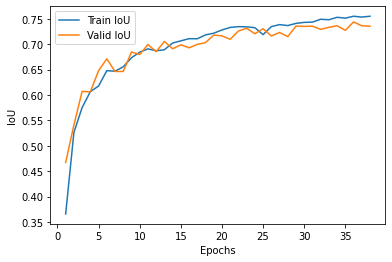


Epoch: 39
valid: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s, cross_entropy_loss - 1.117, iou_score - 0.7386]

Epoch: 40
valid: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s, cross_entropy_loss - 1.115, iou_score - 0.7436]


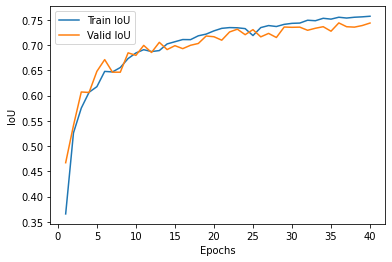


Epoch: 41
valid: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s, cross_entropy_loss - 1.12, iou_score - 0.73]

Epoch: 42
valid: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s, cross_entropy_loss - 1.115, iou_score - 0.7382]


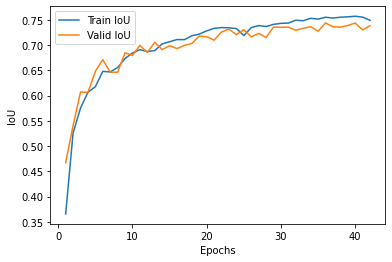


Epoch: 43
valid: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s, cross_entropy_loss - 1.115, iou_score - 0.7427]

Epoch: 44
valid: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s, cross_entropy_loss - 1.113, iou_score - 0.7372]


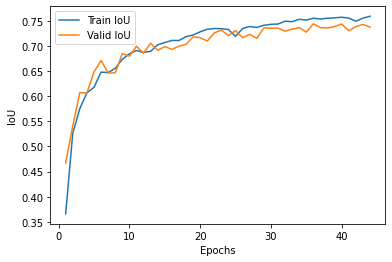


Epoch: 45
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.114, iou_score - 0.7447]
Model saved!

Epoch: 46
valid: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s, cross_entropy_loss - 1.118, iou_score - 0.743]


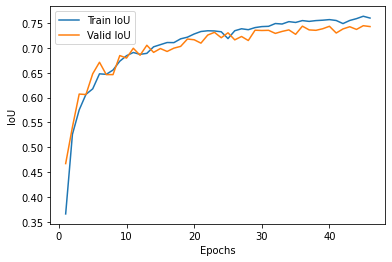


Epoch: 47
valid: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s, cross_entropy_loss - 1.121, iou_score - 0.7083]

Epoch: 48
valid: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s, cross_entropy_loss - 1.117, iou_score - 0.7273]


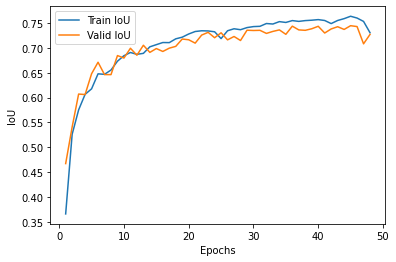


Epoch: 49
valid: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s, cross_entropy_loss - 1.115, iou_score - 0.7382]

Epoch: 50
valid: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s, cross_entropy_loss - 1.115, iou_score - 0.7384]


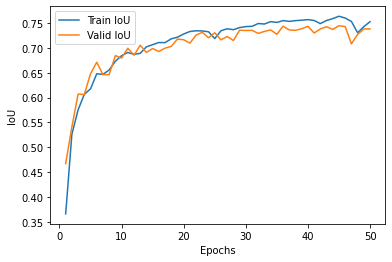


Epoch: 1
valid: 100%|██████████| 6/6 [00:01<00:00,  5.01it/s, cross_entropy_loss - 1.352, iou_score - 0.3371]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s, cross_entropy_loss - 1.233, iou_score - 0.5256]
Model saved!


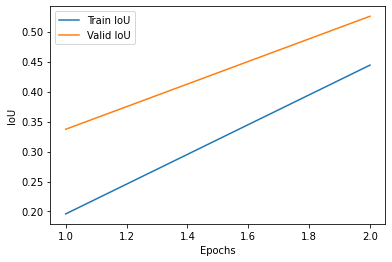


Epoch: 3
valid: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s, cross_entropy_loss - 1.192, iou_score - 0.581]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s, cross_entropy_loss - 1.171, iou_score - 0.6186]
Model saved!


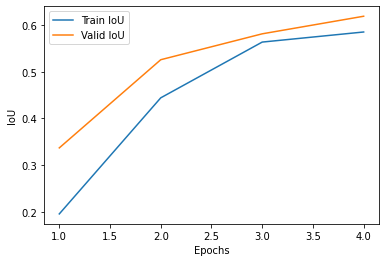


Epoch: 5
valid: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, cross_entropy_loss - 1.157, iou_score - 0.6486]
Model saved!

Epoch: 6
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.148, iou_score - 0.6747]
Model saved!


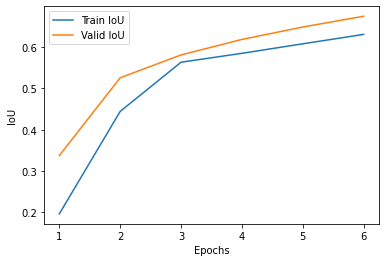


Epoch: 7
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.146, iou_score - 0.6754]
Model saved!

Epoch: 8
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.135, iou_score - 0.6813]
Model saved!


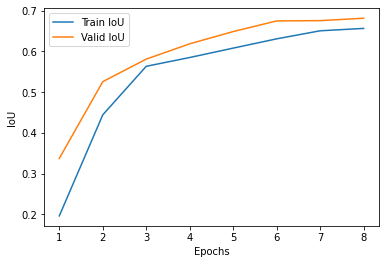


Epoch: 9
valid: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, cross_entropy_loss - 1.141, iou_score - 0.6737]

Epoch: 10
valid: 100%|██████████| 6/6 [00:01<00:00,  5.00it/s, cross_entropy_loss - 1.132, iou_score - 0.686]
Model saved!


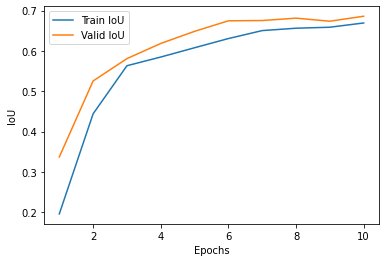


Epoch: 11
valid: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s, cross_entropy_loss - 1.128, iou_score - 0.7066]
Model saved!

Epoch: 12
valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, cross_entropy_loss - 1.128, iou_score - 0.6923]


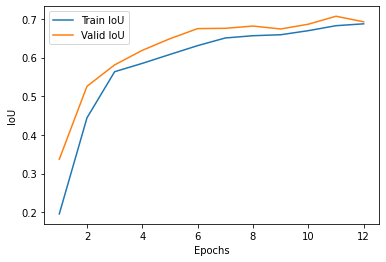


Epoch: 13
valid: 100%|██████████| 6/6 [00:01<00:00,  5.02it/s, cross_entropy_loss - 1.13, iou_score - 0.6839]

Epoch: 14
valid: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s, cross_entropy_loss - 1.125, iou_score - 0.7025]


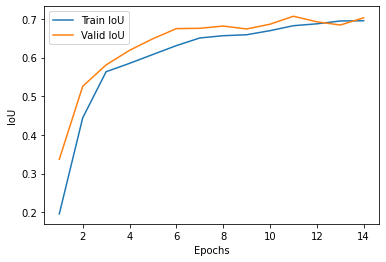


Epoch: 15
valid: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s, cross_entropy_loss - 1.123, iou_score - 0.7168]
Model saved!

Epoch: 16
valid: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s, cross_entropy_loss - 1.125, iou_score - 0.6972]


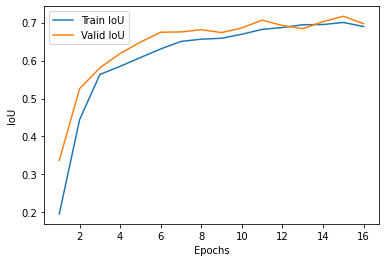


Epoch: 17
valid: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s, cross_entropy_loss - 1.126, iou_score - 0.7013]

Epoch: 18
valid: 100%|██████████| 6/6 [00:01<00:00,  5.03it/s, cross_entropy_loss - 1.122, iou_score - 0.7104]


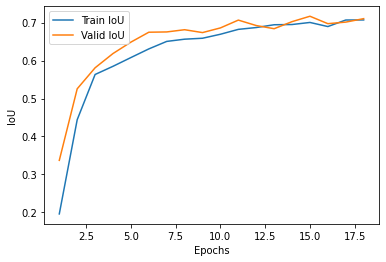


Epoch: 19
valid: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s, cross_entropy_loss - 1.121, iou_score - 0.7232]
Model saved!

Epoch: 20
valid: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s, cross_entropy_loss - 1.122, iou_score - 0.6996]


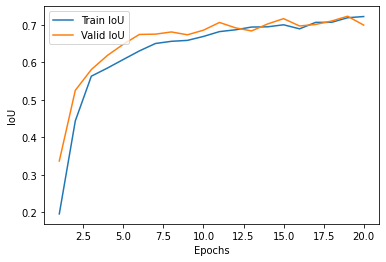


Epoch: 21
valid: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s, cross_entropy_loss - 1.118, iou_score - 0.727]
Model saved!

Epoch: 22
valid: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s, cross_entropy_loss - 1.121, iou_score - 0.7277]
Model saved!


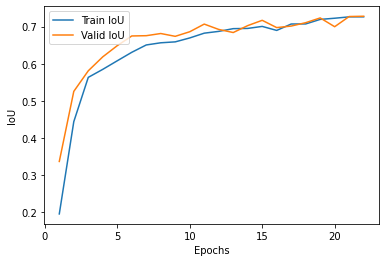


Epoch: 23
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.117, iou_score - 0.7364]
Model saved!

Epoch: 24
valid: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s, cross_entropy_loss - 1.116, iou_score - 0.7322]


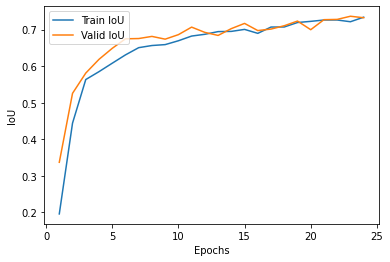


Epoch: 25
valid: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s, cross_entropy_loss - 1.124, iou_score - 0.7138]

Epoch: 26
valid: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s, cross_entropy_loss - 1.12, iou_score - 0.7316]


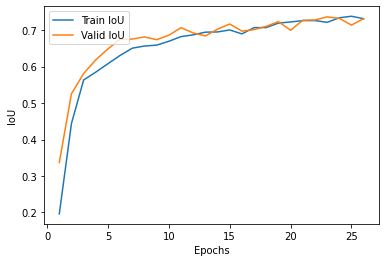


Epoch: 27
valid: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, cross_entropy_loss - 1.116, iou_score - 0.7239]

Epoch: 28
valid: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s, cross_entropy_loss - 1.141, iou_score - 0.6944]


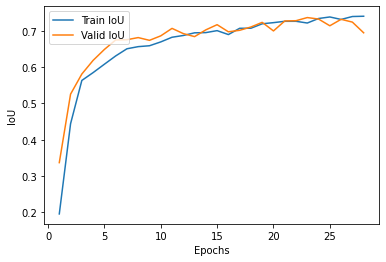


Epoch: 29
valid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, cross_entropy_loss - 1.129, iou_score - 0.7043]

Epoch: 30
valid: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s, cross_entropy_loss - 1.117, iou_score - 0.7352]


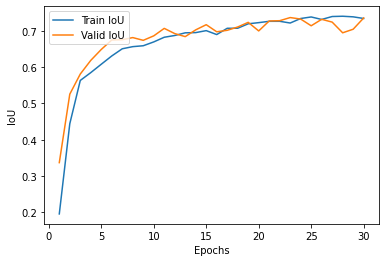


Epoch: 31
valid: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s, cross_entropy_loss - 1.114, iou_score - 0.7453]
Model saved!

Epoch: 32
valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, cross_entropy_loss - 1.115, iou_score - 0.7413]


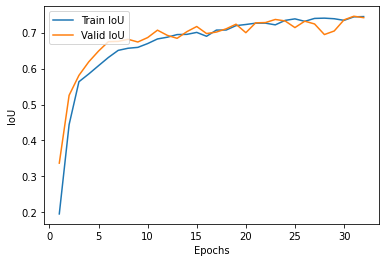


Epoch: 33
valid: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s, cross_entropy_loss - 1.117, iou_score - 0.7415]

Epoch: 34
valid: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s, cross_entropy_loss - 1.116, iou_score - 0.7409]


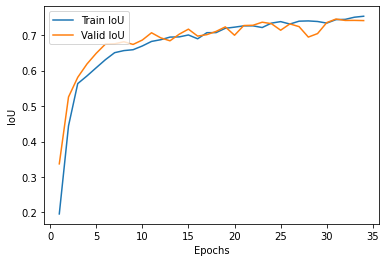


Epoch: 35
valid: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s, cross_entropy_loss - 1.113, iou_score - 0.7497]
Model saved!

Epoch: 36
valid: 100%|██████████| 6/6 [00:01<00:00,  5.00it/s, cross_entropy_loss - 1.346, iou_score - 0.3796]


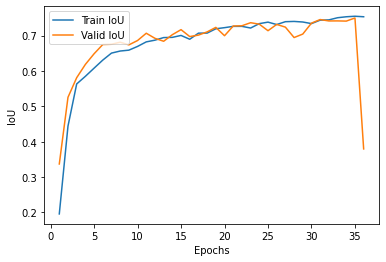


Epoch: 37
valid: 100%|██████████| 6/6 [00:01<00:00,  5.02it/s, cross_entropy_loss - 1.12, iou_score - 0.7286]

Epoch: 38
valid: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s, cross_entropy_loss - 1.141, iou_score - 0.6846]


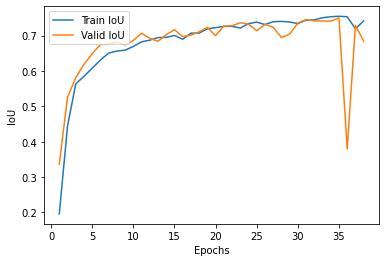


Epoch: 39
valid: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s, cross_entropy_loss - 1.114, iou_score - 0.7354]

Epoch: 40
valid: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s, cross_entropy_loss - 1.112, iou_score - 0.7547]
Model saved!


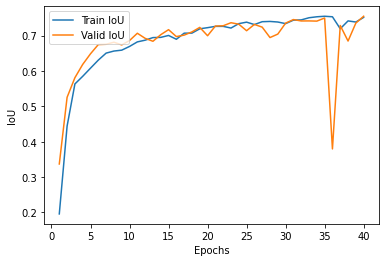


Epoch: 41
valid: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s, cross_entropy_loss - 1.173, iou_score - 0.6284]

Epoch: 42
valid: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s, cross_entropy_loss - 1.113, iou_score - 0.7432]


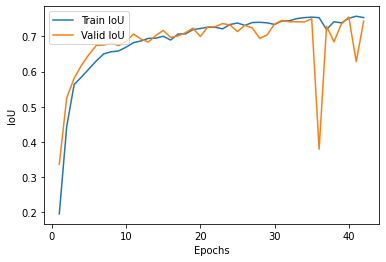


Epoch: 43
valid: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s, cross_entropy_loss - 1.116, iou_score - 0.7427]

Epoch: 44
valid: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s, cross_entropy_loss - 1.11, iou_score - 0.7619]
Model saved!


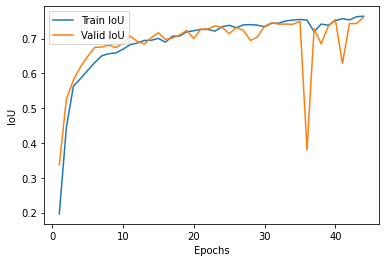


Epoch: 45
valid: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s, cross_entropy_loss - 1.112, iou_score - 0.7536]

Epoch: 46
valid: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s, cross_entropy_loss - 1.113, iou_score - 0.7483]


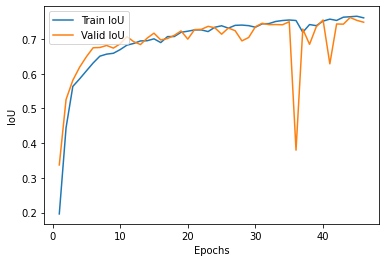


Epoch: 47
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.113, iou_score - 0.7581]

Epoch: 48
valid: 100%|██████████| 6/6 [00:01<00:00,  4.99it/s, cross_entropy_loss - 1.11, iou_score - 0.768]
Model saved!


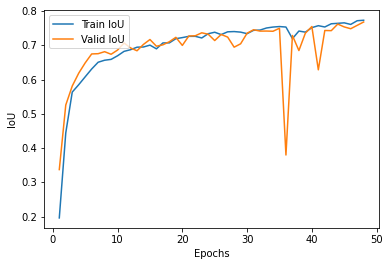


Epoch: 49
valid: 100%|██████████| 6/6 [00:01<00:00,  5.14it/s, cross_entropy_loss - 1.11, iou_score - 0.763]

Epoch: 50
valid: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s, cross_entropy_loss - 1.11, iou_score - 0.7625]


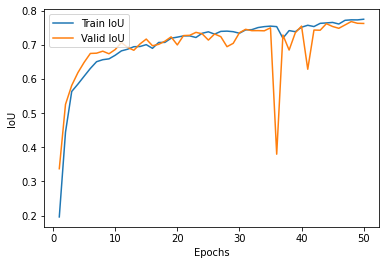


Epoch: 1
valid: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s, cross_entropy_loss - 1.199, iou_score - 0.4934]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s, cross_entropy_loss - 1.168, iou_score - 0.5553]
Model saved!


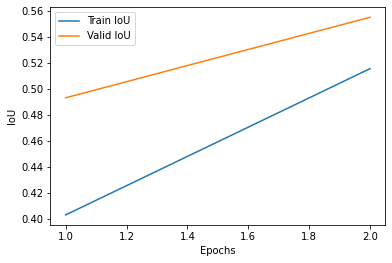


Epoch: 3
valid: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s, cross_entropy_loss - 1.153, iou_score - 0.5783]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:01<00:00,  4.63it/s, cross_entropy_loss - 1.136, iou_score - 0.6324]
Model saved!


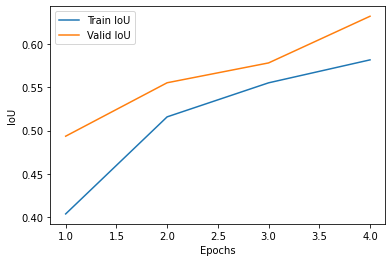


Epoch: 5
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.135, iou_score - 0.6172]

Epoch: 6
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.132, iou_score - 0.6496]
Model saved!


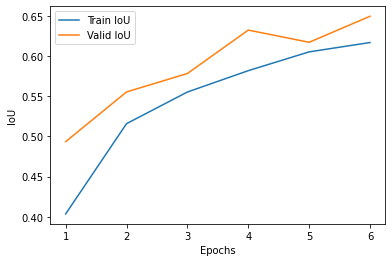


Epoch: 7
valid: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s, cross_entropy_loss - 1.131, iou_score - 0.6499]
Model saved!

Epoch: 8
valid: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s, cross_entropy_loss - 1.208, iou_score - 0.5131]


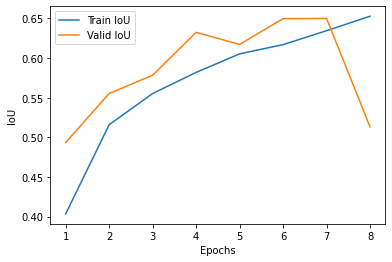


Epoch: 9
valid: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s, cross_entropy_loss - 1.125, iou_score - 0.6768]
Model saved!

Epoch: 10
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.122, iou_score - 0.6839]
Model saved!


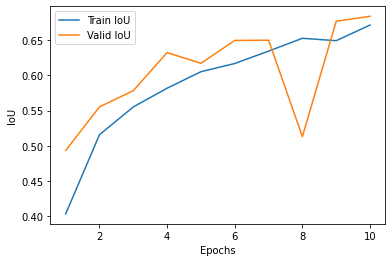


Epoch: 11
valid: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s, cross_entropy_loss - 1.125, iou_score - 0.6864]
Model saved!

Epoch: 12
valid: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s, cross_entropy_loss - 1.14, iou_score - 0.6349]


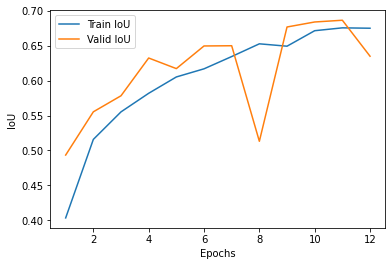


Epoch: 13
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.129, iou_score - 0.6653]

Epoch: 14
valid: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s, cross_entropy_loss - 1.123, iou_score - 0.6963]
Model saved!


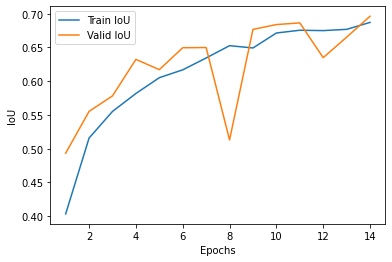


Epoch: 15
valid: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s, cross_entropy_loss - 1.119, iou_score - 0.7072]
Model saved!

Epoch: 16
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.119, iou_score - 0.7095]
Model saved!


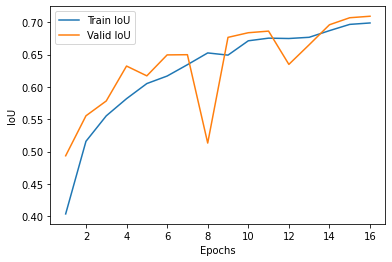


Epoch: 17
valid: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s, cross_entropy_loss - 1.12, iou_score - 0.7029]

Epoch: 18
valid: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s, cross_entropy_loss - 1.122, iou_score - 0.7072]


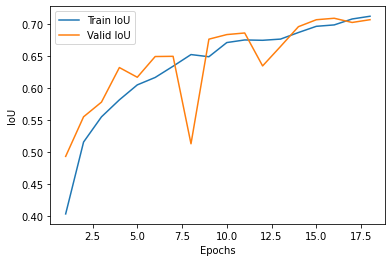


Epoch: 19
valid: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s, cross_entropy_loss - 1.123, iou_score - 0.7011]

Epoch: 20
valid: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s, cross_entropy_loss - 1.122, iou_score - 0.7013]


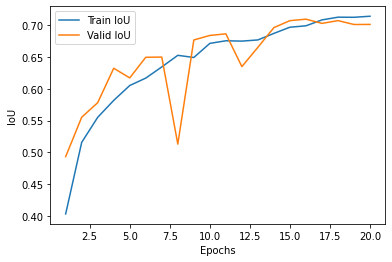


Epoch: 21
valid: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s, cross_entropy_loss - 1.118, iou_score - 0.7198]
Model saved!

Epoch: 22
valid: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s, cross_entropy_loss - 1.12, iou_score - 0.7163]


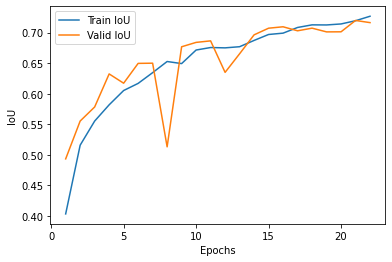


Epoch: 23
valid: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s, cross_entropy_loss - 1.117, iou_score - 0.7124]

Epoch: 24
valid: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s, cross_entropy_loss - 1.117, iou_score - 0.7187]


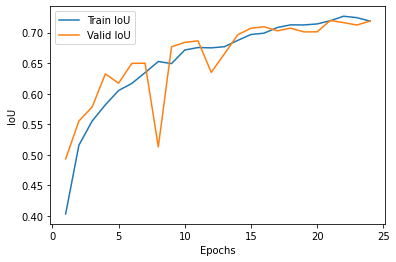


Epoch: 25
valid: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s, cross_entropy_loss - 1.116, iou_score - 0.7298]
Model saved!

Epoch: 26
valid: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s, cross_entropy_loss - 1.116, iou_score - 0.7274]


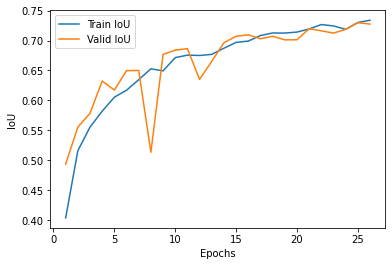


Epoch: 27
valid: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s, cross_entropy_loss - 1.116, iou_score - 0.7293]

Epoch: 28
valid: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s, cross_entropy_loss - 1.119, iou_score - 0.7055]


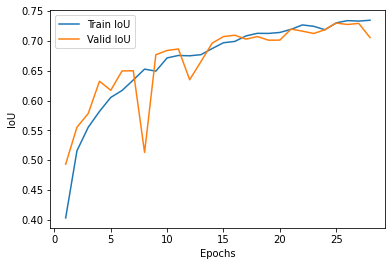


Epoch: 29
valid: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s, cross_entropy_loss - 1.12, iou_score - 0.7165]

Epoch: 30
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.117, iou_score - 0.7322]
Model saved!


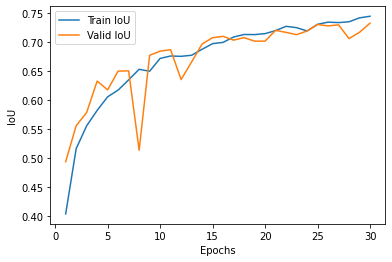


Epoch: 31
valid: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s, cross_entropy_loss - 1.114, iou_score - 0.7352]
Model saved!

Epoch: 32
valid: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s, cross_entropy_loss - 1.115, iou_score - 0.7385]
Model saved!


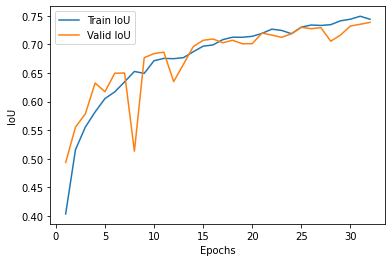


Epoch: 33
valid: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s, cross_entropy_loss - 1.116, iou_score - 0.7398]
Model saved!

Epoch: 34
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.121, iou_score - 0.7126]


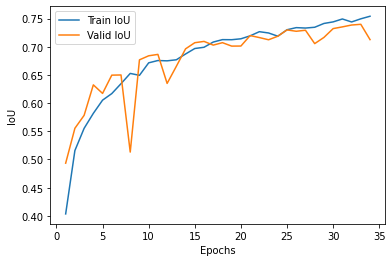


Epoch: 35
valid: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s, cross_entropy_loss - 1.14, iou_score - 0.6531]

Epoch: 36
valid: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s, cross_entropy_loss - 1.117, iou_score - 0.735]


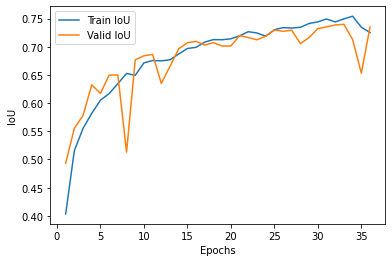


Epoch: 37
valid: 100%|██████████| 6/6 [00:01<00:00,  4.63it/s, cross_entropy_loss - 1.116, iou_score - 0.7271]

Epoch: 38
valid: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s, cross_entropy_loss - 1.116, iou_score - 0.7317]


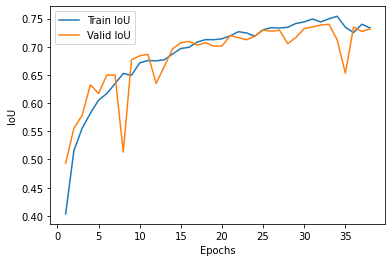


Epoch: 39
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.115, iou_score - 0.7366]

Epoch: 40
valid: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s, cross_entropy_loss - 1.137, iou_score - 0.6639]


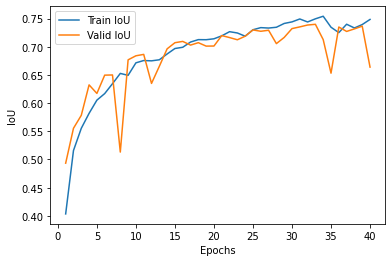


Epoch: 41
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.115, iou_score - 0.739]

Epoch: 42
valid: 100%|██████████| 6/6 [00:01<00:00,  4.63it/s, cross_entropy_loss - 1.113, iou_score - 0.7458]
Model saved!


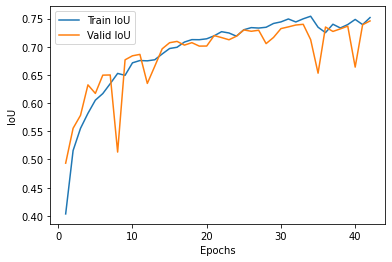


Epoch: 43
valid: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s, cross_entropy_loss - 1.116, iou_score - 0.7398]

Epoch: 44
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.113, iou_score - 0.7478]
Model saved!


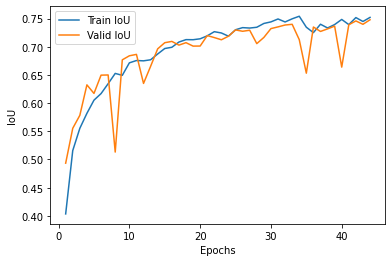


Epoch: 45
valid: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s, cross_entropy_loss - 1.126, iou_score - 0.7202]

Epoch: 46
valid: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s, cross_entropy_loss - 1.215, iou_score - 0.4701]


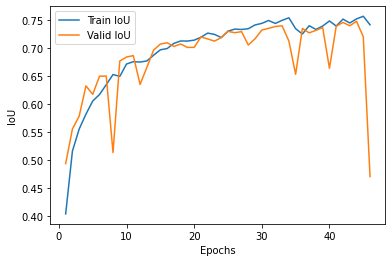


Epoch: 47
valid: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, cross_entropy_loss - 1.119, iou_score - 0.7269]

Epoch: 48
valid: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s, cross_entropy_loss - 1.113, iou_score - 0.7471]


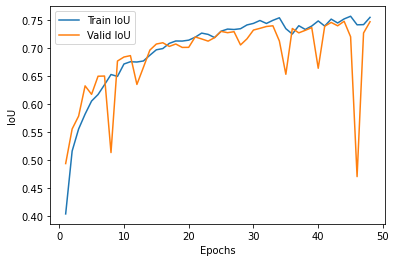


Epoch: 49
valid: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s, cross_entropy_loss - 1.113, iou_score - 0.748]
Model saved!

Epoch: 50
valid: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s, cross_entropy_loss - 1.113, iou_score - 0.7476]


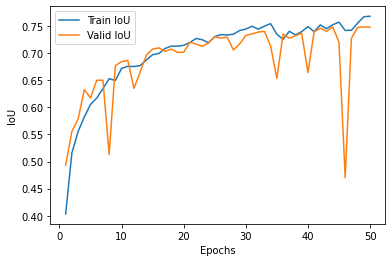


Epoch: 1
valid: 100%|██████████| 6/6 [00:01<00:00,  5.01it/s, cross_entropy_loss - 1.383, iou_score - 0.3167]
Model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:01<00:00,  5.13it/s, cross_entropy_loss - 1.251, iou_score - 0.5055]
Model saved!


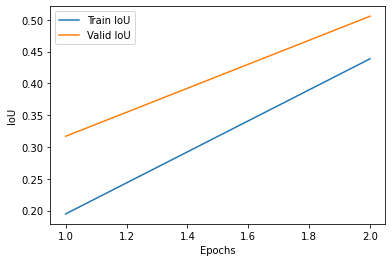


Epoch: 3
valid: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s, cross_entropy_loss - 1.206, iou_score - 0.5506]
Model saved!

Epoch: 4
valid: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s, cross_entropy_loss - 1.187, iou_score - 0.5498]


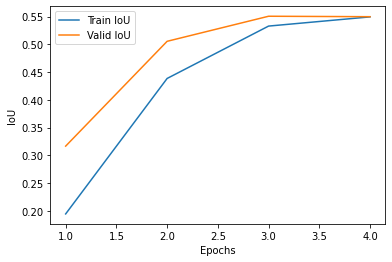


Epoch: 5
valid: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s, cross_entropy_loss - 1.174, iou_score - 0.5652]
Model saved!

Epoch: 6
valid: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s, cross_entropy_loss - 1.169, iou_score - 0.5788]
Model saved!


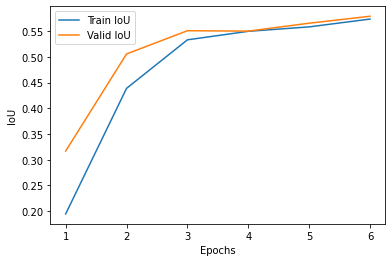


Epoch: 7
valid: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s, cross_entropy_loss - 1.157, iou_score - 0.5851]
Model saved!

Epoch: 8
valid: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s, cross_entropy_loss - 1.153, iou_score - 0.5948]
Model saved!


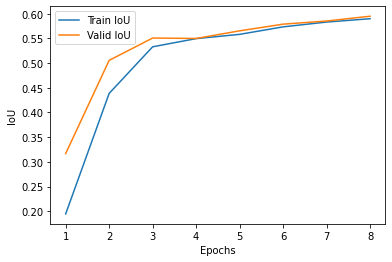


Epoch: 9
valid: 100%|██████████| 6/6 [00:01<00:00,  5.19it/s, cross_entropy_loss - 1.149, iou_score - 0.633]
Model saved!

Epoch: 10
valid: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s, cross_entropy_loss - 1.142, iou_score - 0.6819]
Model saved!


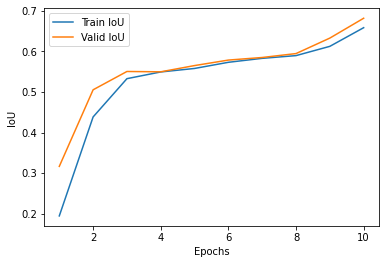


Epoch: 11
valid: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s, cross_entropy_loss - 1.128, iou_score - 0.7047]
Model saved!

Epoch: 12
valid: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s, cross_entropy_loss - 1.126, iou_score - 0.6968]


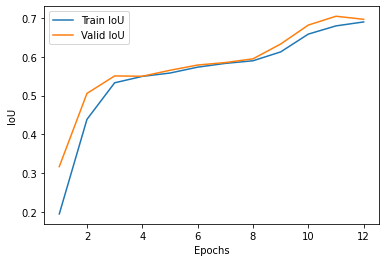


Epoch: 13
valid: 100%|██████████| 6/6 [00:01<00:00,  5.14it/s, cross_entropy_loss - 1.122, iou_score - 0.7159]
Model saved!

Epoch: 14
valid: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s, cross_entropy_loss - 1.123, iou_score - 0.712]


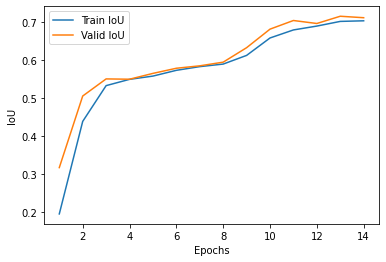


Epoch: 15
valid: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, cross_entropy_loss - 1.121, iou_score - 0.7097]

Epoch: 16
valid: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s, cross_entropy_loss - 1.124, iou_score - 0.7117]


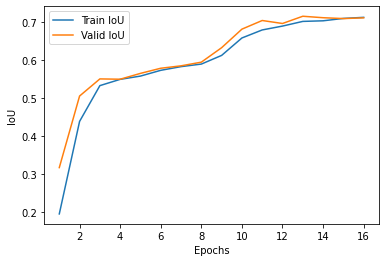


Epoch: 17
valid: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s, cross_entropy_loss - 1.119, iou_score - 0.7319]
Model saved!

Epoch: 18
valid: 100%|██████████| 6/6 [00:01<00:00,  5.15it/s, cross_entropy_loss - 1.117, iou_score - 0.7324]
Model saved!


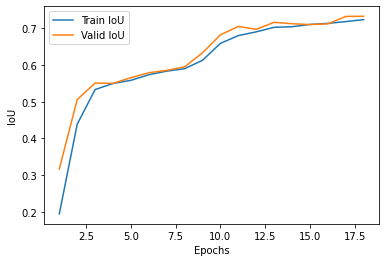


Epoch: 19
valid: 100%|██████████| 6/6 [00:01<00:00,  5.22it/s, cross_entropy_loss - 1.116, iou_score - 0.7393]
Model saved!

Epoch: 20
valid: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s, cross_entropy_loss - 1.118, iou_score - 0.7316]


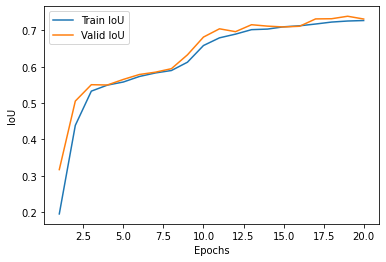


Epoch: 21
valid: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s, cross_entropy_loss - 1.115, iou_score - 0.742]
Model saved!

Epoch: 22
valid: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s, cross_entropy_loss - 1.116, iou_score - 0.7356]


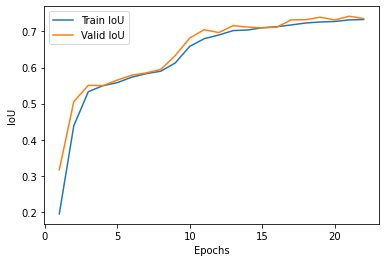


Epoch: 23
valid: 100%|██████████| 6/6 [00:01<00:00,  5.07it/s, cross_entropy_loss - 1.116, iou_score - 0.7294]

Epoch: 24
valid: 100%|██████████| 6/6 [00:01<00:00,  5.08it/s, cross_entropy_loss - 1.114, iou_score - 0.7477]
Model saved!


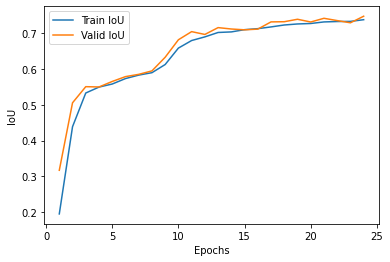


Epoch: 25
valid: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, cross_entropy_loss - 1.119, iou_score - 0.7345]

Epoch: 26
valid: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s, cross_entropy_loss - 1.116, iou_score - 0.7443]


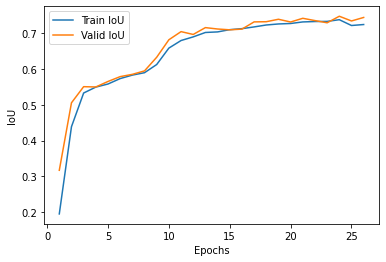


Epoch: 27
valid: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, cross_entropy_loss - 1.114, iou_score - 0.7302]

Epoch: 28
valid: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s, cross_entropy_loss - 1.113, iou_score - 0.747]


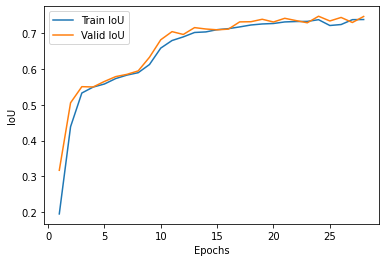


Epoch: 29
valid: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s, cross_entropy_loss - 1.113, iou_score - 0.7451]

Epoch: 30
valid: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s, cross_entropy_loss - 1.113, iou_score - 0.7447]


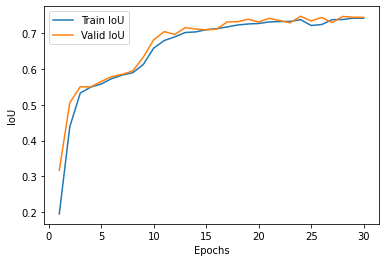


Epoch: 31
valid: 100%|██████████| 6/6 [00:01<00:00,  5.27it/s, cross_entropy_loss - 1.113, iou_score - 0.7503]
Model saved!

Epoch: 32
valid: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s, cross_entropy_loss - 1.115, iou_score - 0.7453]


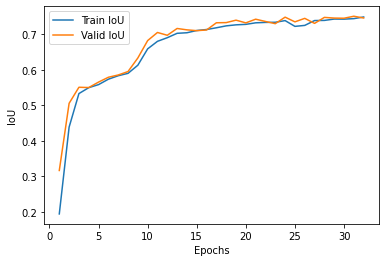


Epoch: 33
valid: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s, cross_entropy_loss - 1.112, iou_score - 0.7495]

Epoch: 34
valid: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s, cross_entropy_loss - 1.112, iou_score - 0.7484]


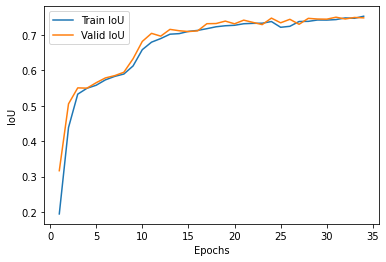


Epoch: 35
valid: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s, cross_entropy_loss - 1.114, iou_score - 0.7477]

Epoch: 36
valid: 100%|██████████| 6/6 [00:01<00:00,  5.17it/s, cross_entropy_loss - 1.113, iou_score - 0.7541]
Model saved!


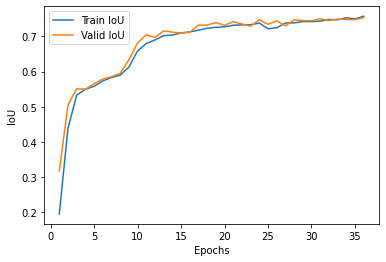


Epoch: 37
valid: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s, cross_entropy_loss - 1.113, iou_score - 0.756]
Model saved!

Epoch: 38
valid: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s, cross_entropy_loss - 1.114, iou_score - 0.7483]


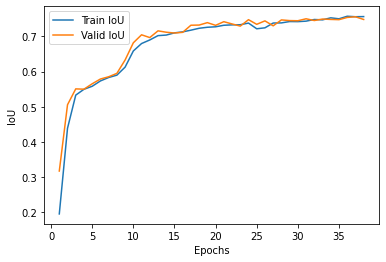


Epoch: 39
valid: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s, cross_entropy_loss - 1.113, iou_score - 0.7505]

Epoch: 40
valid: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s, cross_entropy_loss - 1.114, iou_score - 0.7478]


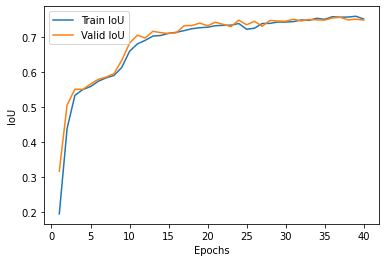


Epoch: 41
valid: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s, cross_entropy_loss - 1.113, iou_score - 0.7516]

Epoch: 42
valid: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s, cross_entropy_loss - 1.114, iou_score - 0.7465]


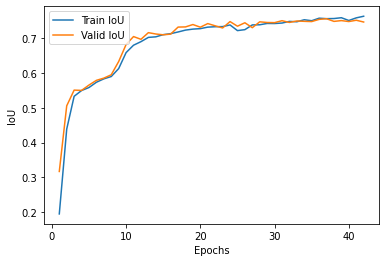


Epoch: 43
valid: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s, cross_entropy_loss - 1.113, iou_score - 0.7492]

Epoch: 44
valid: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s, cross_entropy_loss - 1.113, iou_score - 0.7474]


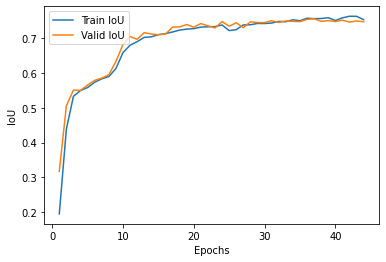


Epoch: 45
valid: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s, cross_entropy_loss - 1.129, iou_score - 0.7143]

Epoch: 46
valid: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s, cross_entropy_loss - 1.113, iou_score - 0.7521]


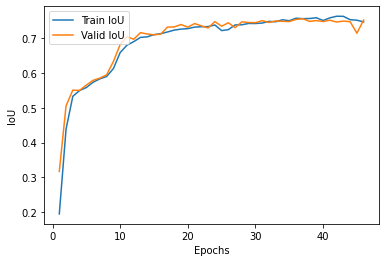


Epoch: 47
valid: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s, cross_entropy_loss - 1.113, iou_score - 0.7409]

Epoch: 48
valid: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s, cross_entropy_loss - 1.125, iou_score - 0.7195]


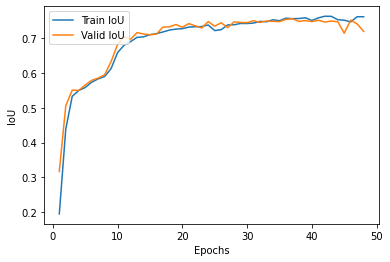


Epoch: 49
valid: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s, cross_entropy_loss - 1.112, iou_score - 0.7483]

Epoch: 50
valid: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s, cross_entropy_loss - 1.111, iou_score - 0.7596]
Model saved!


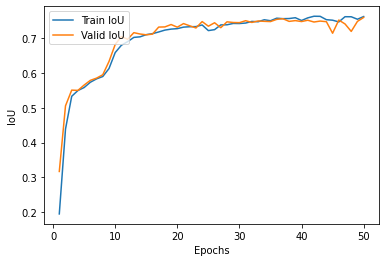

In [355]:
train_model_synth(deeplab, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/deeplab.pth", 50)
train_model_synth(unet, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/unet.pth", 50)
train_model_synth(fcn, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/fcn.pth", 50)
train_model_synth(mobile, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/mobile.pth", 50)